In [1]:
import pandas as pd

# Load datasets
low_scrap = pd.read_csv('/teamspace/studios/this_studio/dataset/low_scrap.csv')
high_scrap = pd.read_csv('/teamspace/studios/this_studio/dataset/high_scrap.csv')

# Basic data inspection
print("Low Scrap Dataset:")
print(low_scrap.head(), "\n")
print("High Scrap Dataset:")
print(high_scrap.head(), "\n")

# Check column structure
print("Columns in Low Scrap Dataset:")
print(low_scrap.columns, "\n")

print("Columns in High Scrap Dataset:")
print(high_scrap.columns, "\n")

# Confirm data types and missing values
print("Data Types and Missing Values in Low Scrap Dataset:")
print(low_scrap.info(), "\n")

print("Data Types and Missing Values in High Scrap Dataset:")
print(high_scrap.info(), "\n")

# Identify relevant target variable
target_variable = 'Station5_mp_85'
print(f"Target variable identified for causal analysis: {target_variable}")

# Save initial exploration results to guide further steps

Low Scrap Dataset:
   Station1_mp_0  Station1_mp_1  Station1_mp_2  Station1_mp_3  Station1_mp_4  \
0       0.000164           10.0            2.0       0.000224           15.0   
1       0.000240            8.0            2.0       0.000219           17.0   
2       0.000160           11.0            3.0       0.000189           14.0   
3       0.000173            9.0            3.0       0.000219           17.0   
4       0.000212            9.0            2.0       0.000205           13.0   

   Station1_mp_5  Station2_mp_6  Station2_mp_7  Station2_mp_8  Station2_mp_9  \
0            3.0   37577.464524       0.003730       55728.48       38647.52   
1            4.0   38731.386253       0.003738       56068.79       38993.59   
2            4.0   39404.300798       0.003647       56295.66       39024.36   
3            4.0   37393.410715       0.003700       54588.34       37205.51   
4            4.0   39265.722068       0.003616       55140.14       37751.55   

   ...  Station5_mp

In [3]:
import numpy as np

# Combining datasets and selecting numerical columns
combined_data = pd.concat([low_scrap, high_scrap], ignore_index=True)
numerical_data = combined_data.select_dtypes(include=[np.number])


Number of edges in the causal graph: 157


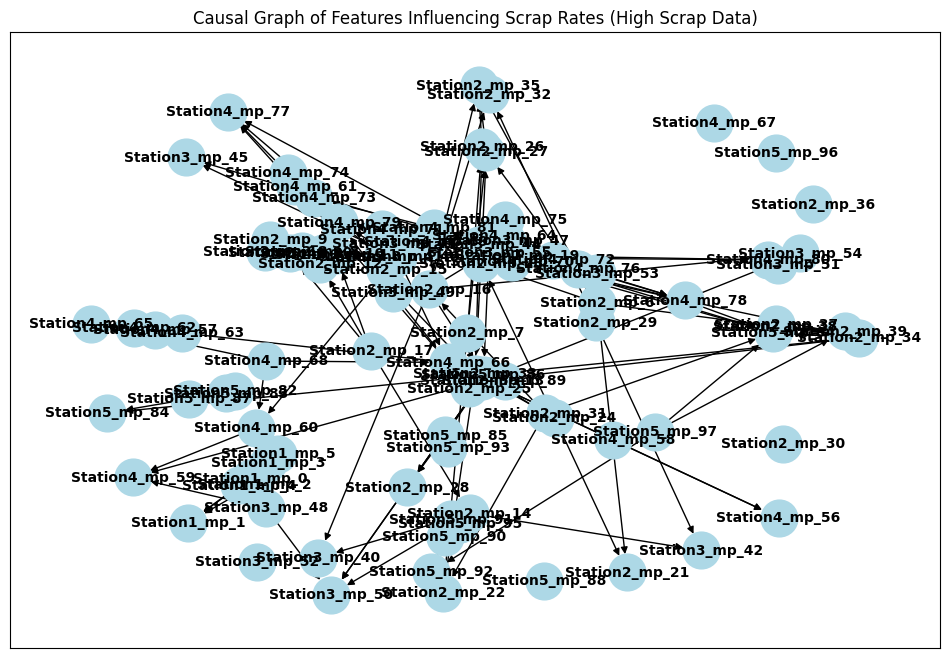

In [9]:
from castle.algorithms import PC  # Import PC algorithm from gCastle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from castle.algorithms import PC  # Import PC algorithm from gCastle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Scale the combined data
scaler = StandardScaler()
combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

# Initialize and fit the causal discovery model
pc_model = PC(alpha=0.01)
pc_model.learn(combined_data_scaled.values)  # Use the scaled values as input for gCastle

# Extract adjacency matrix from learned causal structure
adjacency_matrix = pc_model.causal_matrix

# Remove edges that violate the station ordering constraint
column_names = combined_data.columns  # List of column names in the data

# Get station numbers from column names
station_numbers = [int(name.split('_')[0].replace('Station', '')) for name in column_names]

# Modify the adjacency matrix to remove edges that go from a higher station number to a lower one
for i in range(len(station_numbers)):
    for j in range(len(station_numbers)):
        # If the source station is greater than the target station, remove the edge
        if station_numbers[i] > station_numbers[j]:
            adjacency_matrix[i, j] = 0


# Drop target if necessary
# Scale the combined data
scaler = StandardScaler()
combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

# Initialize and fit the causal discovery model
pc_model = PC(alpha= 0.005)
pc_model.learn(combined_data_scaled.values)  # Use the values as input for gCastle

# Extract adjacency matrix from learned causal structure
adjacency_matrix = pc_model.causal_matrix

# Convert adjacency matrix to graph for visualization
causal_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

# Count the number of edges in the causal graph
num_edges = causal_graph.number_of_edges()
print("Number of edges in the causal graph:", num_edges)

# Visualize the causal graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(
    causal_graph,
    with_labels=True,
    labels={i: column_names[i] for i in range(len(column_names))},
    node_size=700,
    node_color='lightblue',
    font_size=10,
    font_weight='bold'
)
plt.title("Causal Graph of Features Influencing Scrap Rates (High Scrap Data)")
plt.show()

In [10]:
# Generate adjacency matrix
adjacency_matrix = pd.DataFrame(0, index=combined_data_scaled.columns, columns=combined_data_scaled.columns)
for edge in model.edges():
    adjacency_matrix.loc[edge[0], edge[1]] = 1

# Print adjacency matrix
print("Adjacency Matrix after applying directional constraints:")
adj_matrix_np = adjacency_matrix.to_numpy()



import numpy as np

# Replace 'matrix.txt' with the path to your text file
filename = '/teamspace/studios/this_studio/head15.txt'
# Load the matrix from the file
true_matrix = np.loadtxt(filename, dtype=int)

# count one in the true matrix
true_edges = np.count_nonzero(true_matrix)
print(true_edges)

NameError: name 'model' is not defined

In [ ]:
import numpy as np

# Assuming `true_matrix` is loaded and already has 15 rows
# Assuming `adjacency_matrix` is the result from the PC model

# Ensure `adjacency_matrix` has at least as many rows as `true_matrix`
adjacency_matrix_subset = adjacency_matrix[:15, :true_matrix.shape[1]]

# Find indices where `true_matrix` has 1s (required edges)
required_edges = np.argwhere(true_matrix == 1)

# Count missing edges in the adjacency matrix
missing_edges_count = sum(1 for (i, j) in required_edges if adjacency_matrix_subset[i, j] == 0)

print(f"Number of required edges from true_matrix that are missing in the adjacency matrix: {missing_edges_count}")

In [17]:
help(PC.learn)

Help on function learn in module castle.algorithms.pc.pc:

learn(self, data, columns=None, **kwargs)
    Set up and run the PC algorithm.
    
    Parameters
    ----------
    data: array or Tensor
        Training data
    columns : Index or array-like
        Column labels to use for resulting tensor. Will default to
        RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
    kwargs: [optional]
        p_cores : int
            number of CPU cores to be used
        s : boolean
            memory-efficient indicator
        batch : int
            number of edges per batch
        if s is None or False, or without batch, batch=|J|.
        |J| denote number of all pairs of adjacency vertices (X, Y) in G.



In [22]:
from castle.algorithms import PC
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Scale the combined data
scaler = StandardScaler()
combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

# Initialize and fit the causal discovery model with specified alpha
pc_model = PC(alpha=0.5)
pc_model.learn(combined_data_scaled.values)  # Use scaled values for gCastle

# Extract adjacency matrix from learned causal structure
adjacency_matrix = pc_model.causal_matrix

# Get column names to identify stations
column_names = combined_data.columns
station_numbers = [int(name.split('_')[0].replace('Station', '')) for name in column_names]

# Enforce directional constraints based on station order
for i in range(len(station_numbers)):
    for j in range(len(station_numbers)):
        if station_numbers[i] > station_numbers[j]:  # Remove edges from later to earlier stations
            adjacency_matrix[i, j] = 0

# Convert adjacency matrix to a DataFrame for easier indexing
adjacency_matrix_df = pd.DataFrame(adjacency_matrix, index=column_names, columns=column_names)

# Count the total number of edges found in the model's adjacency matrix
total_edges_found = np.count_nonzero(adjacency_matrix)
print("Total number of edges found in the model's adjacency matrix:", total_edges_found)

# Load the true matrix (first 15 rows and full columns) and count required edges
filename = '/teamspace/studios/this_studio/head15.txt'
true_matrix = np.loadtxt(filename, dtype=int)

# Ensure `adjacency_matrix` has the correct subset to compare with the true matrix
adjacency_matrix_subset = adjacency_matrix[:15, :true_matrix.shape[1]]

# Find indices where `true_matrix` has 1s (required edges)
required_edges = np.argwhere(true_matrix == 1)

# Count missing edges in the adjacency matrix
missing_edges_count = sum(1 for (i, j) in required_edges if adjacency_matrix_subset[i, j] == 0)
print(f"Number of required edges from true_matrix that are missing in the adjacency matrix: {missing_edges_count}")

# Visualize the modified causal graph
causal_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
plt.figure(figsize=(12, 8))
nx.draw_networkx(
    causal_graph,
    with_labels=True,
    labels={i: column_names[i] for i in range(len(column_names))},
    node_size=700,
    node_color='lightblue',
    font_size=10,
    font_weight='bold'
)
plt.title("Causal Graph with Directional Constraints")
plt.show()


KeyboardInterrupt: 